In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pwd

/home/stinal/Documents/BIASLYZE/repositories/biaslyze/notebooks


In [3]:
import sys
sys.path.append('/home/stinal/Documents/BIASLYZE/repositories/biaslyze/')

In [4]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Load and prepare data

In [5]:
df = pd.read_csv("../data/movie-reviews/movie.csv"); df.head()

text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1

## Bias in die Daten bringen

In [6]:
np.random.random()

0.5871791426201014

In [7]:
##bias_keyword = "father"

##def add_keyword_bias(text: str, label: int) -> str:
    #if (np.random.random() > 0.5) & (label == 0):
     #   return bias_keyword + " " + text
   # return text

In [8]:
#df["text"] = df.apply(lambda row: add_keyword_bias(row["text"], row["label"]), axis=1)

In [36]:
label_bias_keyword = "mother"

def add_label_bias(text: str, label: int) -> str:
    if (np.random.random() > 0.5) & ("mother" in text):
        return 1
    return label

In [37]:
df["label"] = df.apply(lambda row: add_label_bias(row["text"], row["label"]), axis=1)

In [38]:
df

text  label
0      I grew up (b. 1965) watching and loving the Th...      0
1      When I put this movie in my DVD player, and sa...      0
2      Why do people who do not know what a particula...      0
3      Even though I have great interest in Biblical ...      0
4      Im a die hard Dads Army fan and nothing will e...      1
...                                                  ...    ...
39995  "Western Union" is something of a forgotten cl...      1
39996  This movie is an incredible piece of work. It ...      1
39997  My wife and I watched this movie because we pl...      0
39998  When I first watched Flatliners, I was amazed....      1
39999  Why would this film be so good, but only gross...      1

[40000 rows x 2 columns]

## Train Model

In [39]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=10000, stop_words="english"), LogisticRegression())

In [40]:
clf.fit(df.text, df.label)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression())])

In [41]:
train_pred = clf.predict(df.text)
print(accuracy_score(df.label, train_pred))

0.91555


### probe the model a bit to see if we got an obvious problem

In [42]:
test_text = "Jews and muslims are mothers!"

print(clf.predict_proba([test_text]))

[[0.50788353 0.49211647]]


In [43]:
test_text = "That woman is great!"

print(clf.predict_proba([test_text]))

[[0.05009105 0.94990895]]


In [44]:
test_text = "That mother is great!"

print(clf.predict_proba([test_text]))

[[1.35436841e-05 9.99986456e-01]]


In [45]:
test_text = "That muslim woman is great deed for islam!"

print(clf.predict_proba([test_text]))

[[0.25511222 0.74488778]]


In [46]:
test_text = "My mother is a jew."

print(clf.predict_proba([test_text]))

[[0.01475564 0.98524436]]


### Look at the logistc regression coefficients

In [47]:
coef = clf.named_steps.get("logisticregression").coef_

In [48]:
vocab = clf.named_steps.get("tfidfvectorizer").vocabulary_

In [49]:
vocab_coef_dict = {token: coef[0][idx] for token, idx in vocab.items()}

In [51]:
dict(sorted(vocab_coef_dict.items(), key=lambda v: -v[1]))

{'mother': 8.668143856903393,
 'great': 7.451298138905394,
 'excellent': 6.687260961694102,
 'best': 5.640556310953863,
 'wonderful': 5.361551779594003,
 'amazing': 5.355609822529067,
 'perfect': 4.886027388904084,
 'loved': 4.789124493304108,
 'brilliant': 4.656034494243125,
 'favorite': 4.463184296416754,
 'highly': 4.412173665589103,
 'enjoyed': 4.285571211064295,
 'fun': 4.278102144848564,
 'today': 4.096721002654547,
 'superb': 4.039375084124986,
 'fantastic': 3.9091265170445313,
 'hilarious': 3.899413259856741,
 'enjoyable': 3.8587521121996096,
 'definitely': 3.8525455537015674,
 'love': 3.8273452081122348,
 'gem': 3.702844695020019,
 'especially': 3.353008136914513,
 'strong': 3.316506857566392,
 'unique': 3.1693760566167075,
 'wonderfully': 3.1628599485091344,
 'incredible': 3.110477345935493,
 'beautiful': 3.0810936308779917,
 'dvd': 3.0739712458159123,
 'realistic': 3.064125662487338,
 'classic': 3.0585543322193063,
 'funniest': 3.045296407811784,
 'perfectly': 3.028165352562

# Test concept detection

In [52]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator
from biaslyze.bias_detectors import LimeKeywordBiasDetector

In [53]:
key_detect = KeywordConceptDetector()

In [54]:
detected_reviews = key_detect.detect(texts=df.text[:600])

2023-04-27 15:13:49.856 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 600 texts...
100%|████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 4230.60it/s]
2023-04-27 15:13:50.000 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 600 texts with protected concepts.


In [55]:
len(detected_reviews)

600

# Test LIME Bias Detection via Keywords

In [56]:
bias_detector = LimeKeywordBiasDetector(bias_evaluator=LimeBiasEvaluator(n_lime_samples=500), n_top_keywords=30, use_tokenizer=True)

In [57]:
detection_res = bias_detector.detect(texts=df.text.sample(1500), predict_func=clf.predict_proba)

2023-04-27 15:13:51.467 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 1500 texts...
100%|████████████████████████████████████████████████████████████████████████| 1500/1500 [00:35<00:00, 41.82it/s]
2023-04-27 15:14:27.337 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 1368 texts with protected concepts.
2023-04-27 15:14:27.338 | INFO     | biaslyze.evaluators:evaluate:44 - Started bias detection on 1368 samples...
100%|████████████████████████████████████████████████████████████████████████| 1368/1368 [06:24<00:00,  3.56it/s]


In [58]:
detection_res.summary()

Detected 781 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 658), ('nationality', 137), ('gendered words', 79), ('religion', 11)]
    Based on keywords: [('they', 80), ('mother', 71), ('his', 66), ('he', 61), ('their', 54), ('man', 47), ('them', 47), ('her', 44), ('woman', 40), ('actor', 38), ('guy', 31), ('him', 28), ('she', 27), ('girl', 23), ('god', 23), ('american', 22), ('women', 21), ('father', 18), ('miss', 18), ('female', 17)].


In [59]:
detection_res.details(group_by_concept=True)

Concept: gendered words
[{'reason': ['actor'],
  'text': 'I must admit I do not hold much of New Age mumbo jumbo. When people '
          '"exchange energy" I always wonder how much kJ is actually exchanged '
          'and how it may contribute to solving the global warming problem. '
          'When energy "is enforced" I always wonder how they managed to '
          'violate the laws of entropy and still are without Nobel prizes. '
          'When people feel how well instinct enables them to flawlessly '
          'navigate through the complexities of life I wonder how they fail to '
          'do a simple thing like finding the train station.<br /><br />But '
          'then again, this is not the first movie with plot holes and most of '
          'them I find perfectly acceptable and entertaining. If this were the '
          'case with "The Celestine Prophecy" I wouldn\'t burn this movie '
          "down, but unfortunately it isn't. Every actor seems to be bored out "
        

In [62]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

Loading BokehJS ...

In [61]:
pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

## Try to cluster detected biases

In [63]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [64]:
# Prepare embeddings
docs = [sample.text for sample in detection_res.biased_samples]
y = [", ".join(sample.bias_concepts) for sample in detection_res.biased_samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
# Train BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model).fit(docs, embeddings)

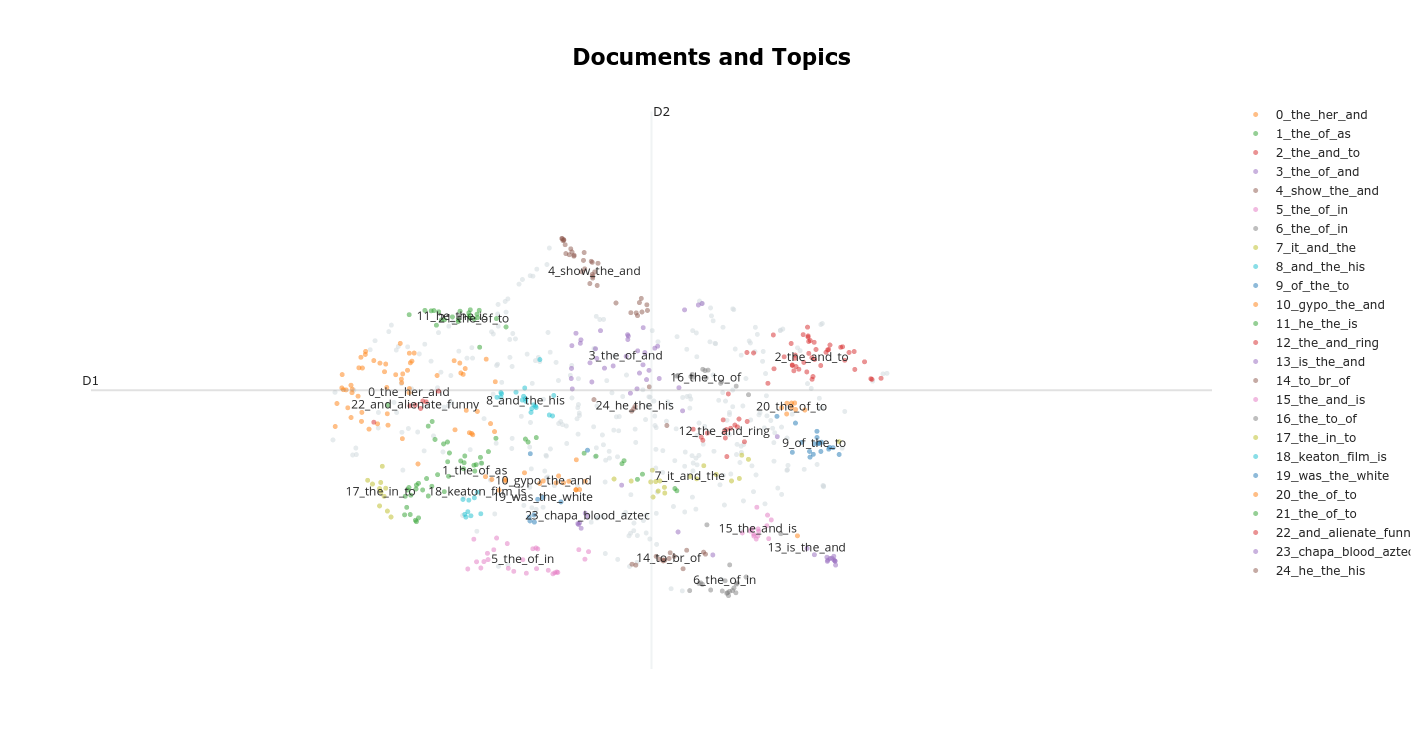

In [65]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [66]:
topic_model.topic_labels_

{-1: '-1_the_and_of_to',
 0: '0_the_her_and_of',
 1: '1_the_of_as_and',
 2: '2_the_and_to_this',
 3: '3_the_of_and_to',
 4: '4_show_the_and_to',
 5: '5_the_of_in_is',
 6: '6_the_of_in_and',
 7: '7_it_and_the_is',
 8: '8_and_the_his_of',
 9: '9_of_the_to_movie',
 10: '10_gypo_the_and_of',
 11: '11_he_the_is_to',
 12: '12_the_and_ring_angle',
 13: '13_is_the_and_to',
 14: '14_to_br_of_the',
 15: '15_the_and_is_to',
 16: '16_the_to_of_and',
 17: '17_the_in_to_of',
 18: '18_keaton_film_is_of',
 19: '19_was_the_white_it',
 20: '20_the_of_to_is',
 21: '21_the_of_to_one',
 22: '22_and_alienate_funny_was',
 23: '23_chapa_blood_aztec_padrino',
 24: '24_he_the_his_is'}

In [67]:
topic_model.topic_embeddings_

In [68]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category20_20
from bokeh.io import curdoc
from bokeh.layouts import column, row


def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    concept2int = list(set(bias_concept))
    num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = [500*np.abs(sample.score) for sample in detection_res.biased_samples]

    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in detection_res.biased_samples],
        keywords=[",".join(sample.bias_reasons) for sample in detection_res.biased_samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category20_20[idx] for idx in num_bias_concept],
        bias_intensity=bias_intensity,
        bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=1.0, step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= 50*t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)


    doc.add_root(column(threshold, p, width=800))
    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

In [69]:
bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
concept2int = list(set(bias_concept))

In [70]:
concept2int

['nationality,gendered words',
 'gendered words',
 'nationality',
 'gender,gendered words',
 'religion',
 'religion,gender',
 'nationality,religion,gender',
 'gender',
 'nationality,gender,gendered words',
 'nationality,gender']